In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gaussian_mixture_grid import GaussianMixtureGrid
import numpy as np
import pymc3 as pm
%matplotlib inline


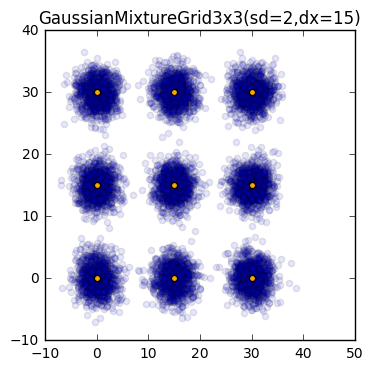

In [27]:
gri2d = GaussianMixtureGrid(length=3, dimensionality=2, spacing=15, stddev=2) 
# spacing 10 -- works well
# spacing 30 -- only finds one mode
plt.figure(figsize=(4,4))
plt.title(gri2d.name)
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.scatter(*gri2d.means.T, c='orange')
plt.show()

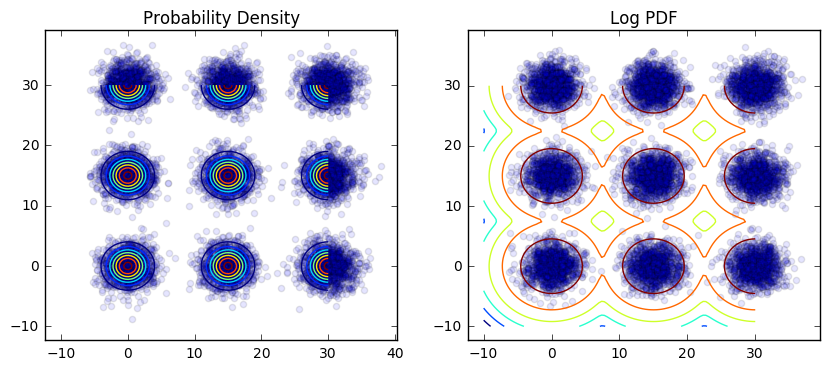

In [28]:
s = np.linspace(-10,30,100)
X,Y = np.meshgrid(s,s)
Z = [[gri2d.logp([x,y]) for x in s] for y in s]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Probability Density')
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.contour(X,Y,np.exp(Z))
plt.subplot(122)
plt.title('Log PDF')
plt.contour(X,Y,Z)
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.show()

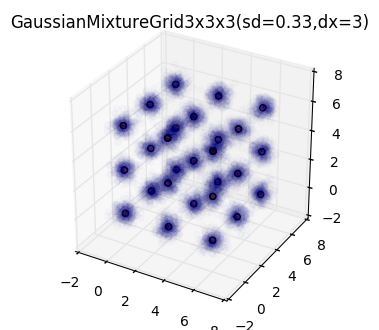

In [29]:
gri3d = GaussianMixtureGrid(3, 3, 3, 0.33)
X, Y, Z = gri3d.sample(10000).T
Xu, Yu, Zu = gri3d.means.T

plt.figure(figsize=(4,4)).add_subplot(111, projection='3d')
plt.title(gri3d.name)
plt.scatter(X, Y, zs=Z, alpha=0.01)
plt.scatter(Xu, Yu, zs=Zu, c='orange')
plt.show()

# Nuts vs Metropolis

In [30]:
N_SAMPLES = 200000
N_JOBS = 1

# NUTS
with pm.Model() as model_nuts:
  mix_nuts = gri2d.to_pymc()
  trace_nuts = pm.sample(N_SAMPLES)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2.2116: 100%|██████████| 200000/200000 [00:09<00:00, 20533.87it/s]
Finished [100%]: Average ELBO = -2.2096
100%|██████████| 200000/200000 [00:42<00:00, 4698.09it/s]


In [21]:
# METROPOLIS
with pm.Model() as model_metropolis:
    # generalize start
    mix_metropolis = gri2d.to_pymc()
    trace_metropolis = pm.sample(N_SAMPLES, step=pm.Metropolis(tune=False), progressbar=True, njobs=N_JOBS)    

100%|██████████| 10000/10000 [00:00<00:00, 10922.58it/s]


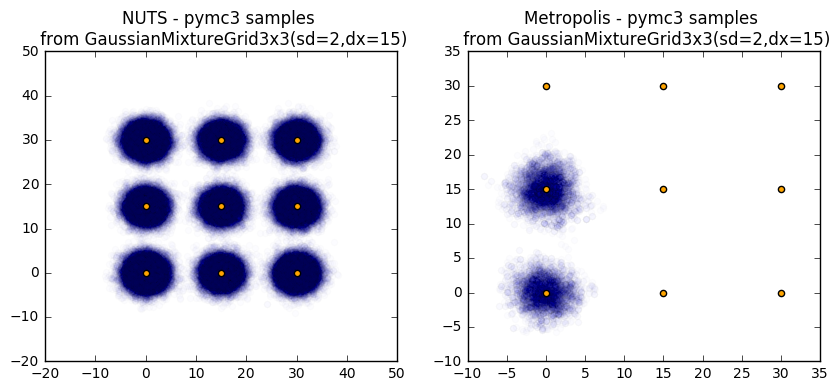

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('NUTS - pymc3 samples \n from {}'.format(gri2d))
plt.scatter(*trace_nuts[gri2d.name].T, alpha=0.01)
plt.scatter(*gri2d.means.T, c='orange')

plt.subplot(1,2,2)
plt.title('Metropolis - pymc3 samples \n from {}'.format(gri2d))
plt.scatter(*trace_metropolis[gri2d.name].T, alpha=0.01)
plt.scatter(*gri2d.means.T, c='orange')


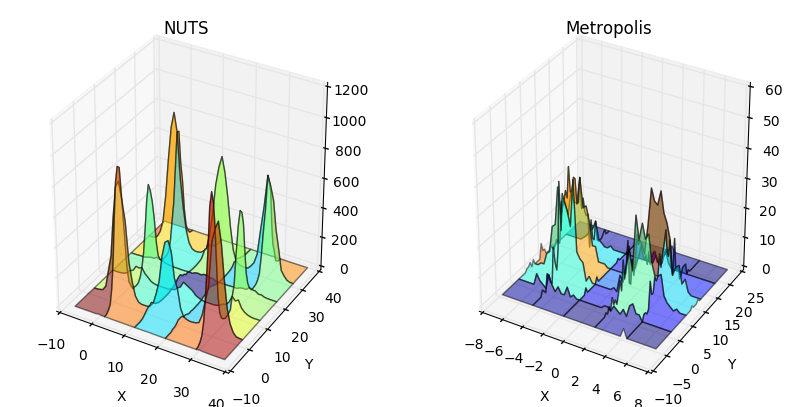

In [32]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1, projection='3d')

H, xbins, ybins = np.histogram2d(*trace_nuts[gri2d.name].T, bins=50)
X, Y = np.meshgrid(xbins[1:], ybins[1:])
ax.plot_surface(X, Y, H, cmap=plt.cm.jet, alpha=.5)
# ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.7, rstride=20, cstride=20)
ax.set_title("NUTS")
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax = fig.add_subplot(1, 2, 2, projection='3d')
H, xbins, ybins = np.histogram2d(*trace_metropolis[gri2d.name].T, bins=50)
X, Y = np.meshgrid(xbins[1:], ybins[1:])
ax.plot_surface(X, Y, H, cmap=plt.cm.jet, alpha=.5)
# ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.7, rstride=20, cstride=20)
ax.set_title("Metropolis")
ax.set_xlabel("X")
ax.set_ylabel("Y")



# Diagnostics

Sources:

* https://pymc-devs.github.io/pymc3/api/diagnostics.html
* https://pymc-devs.github.io/pymc3/api/plots.html
* http://rlhick.people.wm.edu/stories/bayesian_5.html
        

# Plots on offer

## 1. Posterior marginals - we would want each mode to be equally represented

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f49e7c908d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f49fe1aa0f0>], dtype=object)

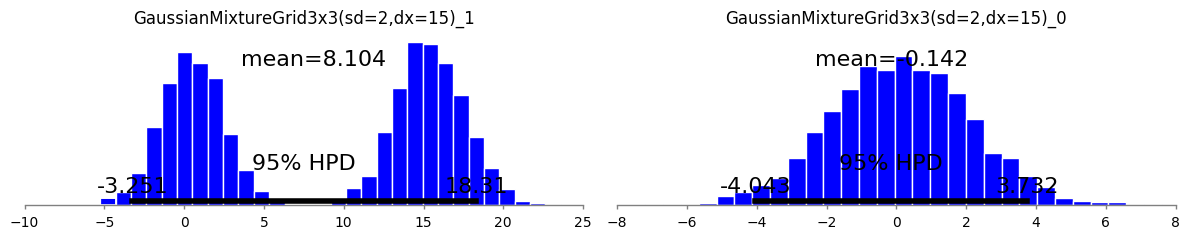

In [33]:
pm.plots.plot_posterior(trace_metropolis)

## 2. Traceplot - posterior marginals again with the trace

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49ec486828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f49e7f9b3c8>]], dtype=object)

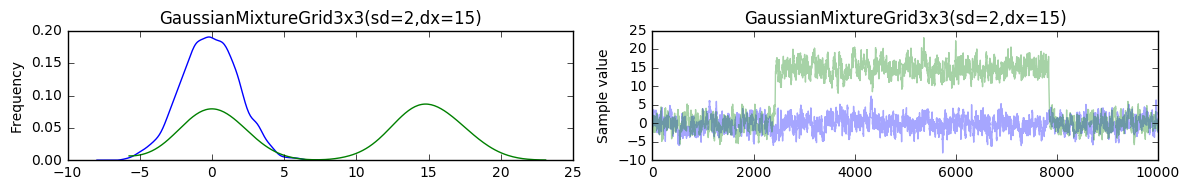

In [34]:
pm.plots.traceplot(trace_metropolis)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49e7eed0b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f49e7eb96d8>]], dtype=object)

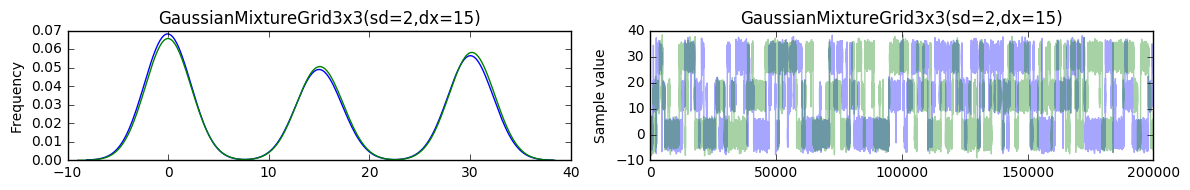

In [35]:
pm.plots.traceplot(trace_nuts)

## 3. Forestplot - don't think this one is useful to us

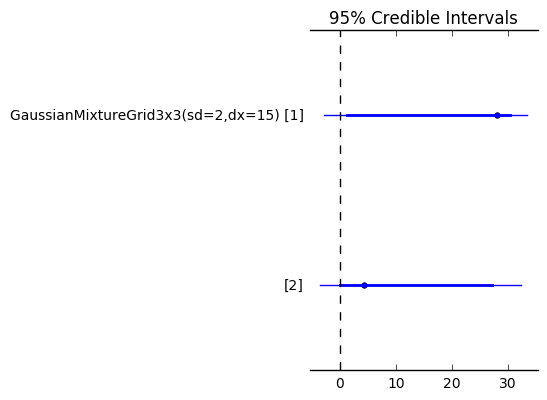

In [12]:
pm.plots.forestplot(trace_metropolis)

# Diagnostics

## 1. Autocorrelation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49ec2ade80>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f49ec053cc0>]], dtype=object)

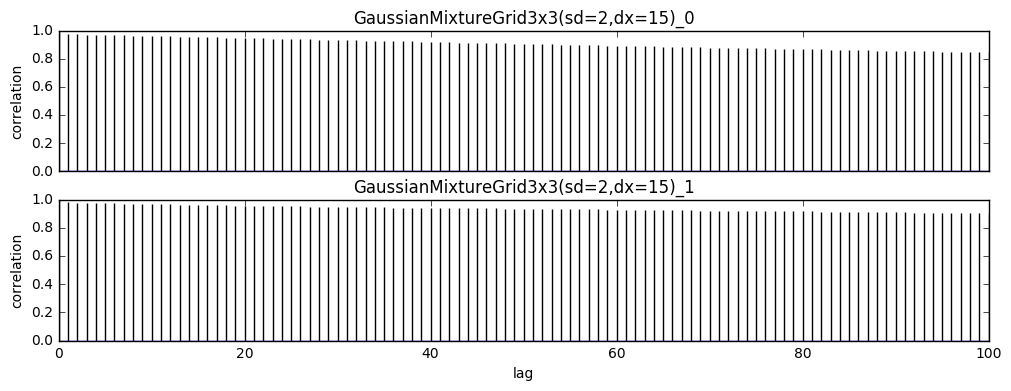

In [24]:
pm.plots.autocorrplot(trace_nuts)

## This seems sketchy. Doesn't match up with what we'd expect given traceplots above.


## 2. Geweke

* If we have adequately culled the burnin expect to fail to reject the null that the mean for the first 10% and the mean of any interval in the last 50% is the same.

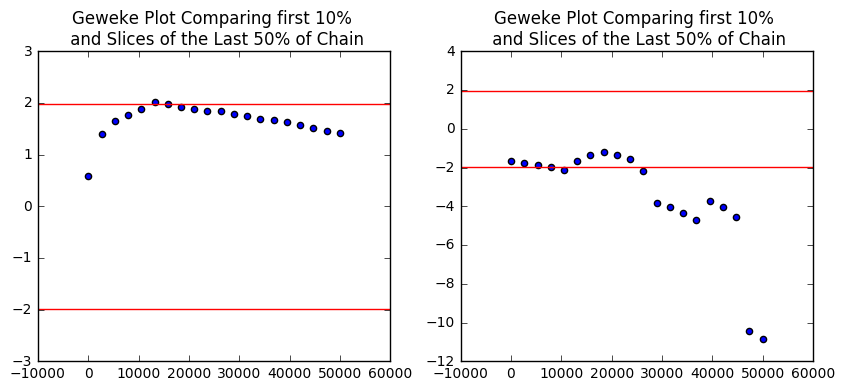

In [14]:
gw_plot = pm.geweke(trace_metropolis,.1,.5,20)

plt.figure(figsize=(10,4))
for dim, geweke_dim in enumerate(gw_plot[gri2d.name]):
    plt.subplot(1,2,dim+1)
    plt.scatter(*geweke_dim.T)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.title('Geweke Plot Comparing first 10% \n and Slices of the Last 50% of Chain')


## 3. Gelman-Rubin

In [15]:
# # METROPOLIS
# with pm.Model() as model_metropolis2:
#     # generalize start
#     mix_metropolis2 = gri2d.to_pymc()
#     trace_metropolis2 = pm.sample(N_SAMPLES, step=pm.Metropolis(), progressbar=True, njobs=2)

In [16]:
# pm.diagnostics.gelman_rubin(trace_metropolis2)

pymc3 bugged 
* https://github.com/pymc-devs/pymc3/issues/1033
* compares between and within chain variance, so needs multiple jobs. However, when you choose njobs>1 we run into a pymc3 bug.
* rule of thumb. want this as close to 1 as possible. in particular when this is greater than 1.1 a longer burn-in is needed.

## 4. Effective Sample Size

In [17]:
# pm.diagnostics.effective_n(trace_metropolis2)

* Also expects a multitrace so sadly bugged. 


# Our own diagnostics

In [69]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from sklearn.metrics import r2_score

In [74]:
N_SAMPLES = trace_nuts.get_values(gri2d.name).shape[0]
EPOCHS = 10
WINDOWS = np.arange(0,N_SAMPLES,N_SAMPLES//EPOCHS)

dim = 0
space_of_dim = np.linspace(-10,40,100)
r2_score_list = []

for i in range(10):
    # generate kernel
    kernel = gaussian_kde(trace_nuts[0:WINDOWS[i]+20000].get_values(gri2d.name)[:,dim])
    kernel_vals = kernel(space_of_dim)

    # get true marginal density
    true_density = np.zeros(len(space_of_dim))
    for i in range(true_density.shape[0]):
        true_density[i] = quad(lambda x: np.exp(gri2d.logp([x,space_of_dim[i]])), -10, 40)[0]

    # get r2
    r2_score_list.append(r2_score(true_density, kernel_vals))

In [75]:
r2_score_list

[0.86564317925311562,
 0.92638616659481521,
 0.93705896221188867,
 0.89857227894633807,
 0.83153383772189204,
 0.91859831053902652,
 0.95664072031858316,
 0.95541584631900578,
 0.95772719444420318,
 0.95018697258281115]

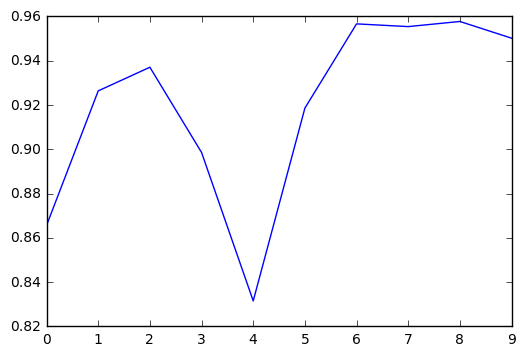

In [76]:
plt.plot(r2_score_list)

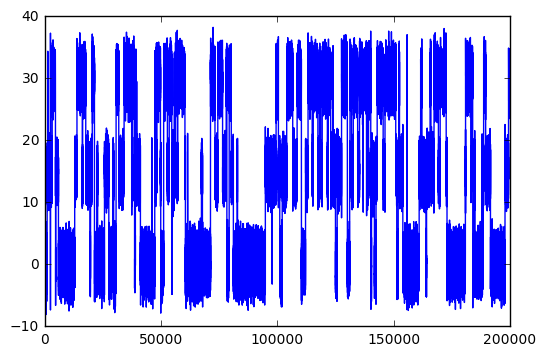

In [62]:
plt.plot(trace_nuts.get_values(gri2d.name)[:,0])

# Working

### Sanity check on integrals of density functions

In [3]:
from scipy.integrate import quad

# sanity check
gri1d = GaussianMixtureGrid(length=3, dimensionality=1, spacing=15, stddev=2) 
quad(lambda x: np.exp(gri1d.logp(x)), -10, 40)


In [ ]:
# sanity check 2d
from scipy.integrate import dblquad

def I():
    return dblquad(lambda x,y: np.exp(gri2d.logp([x,y])), -10, 40, lambda x:-10, lambda x:40)
I()

### Plot intuition of residual calculation

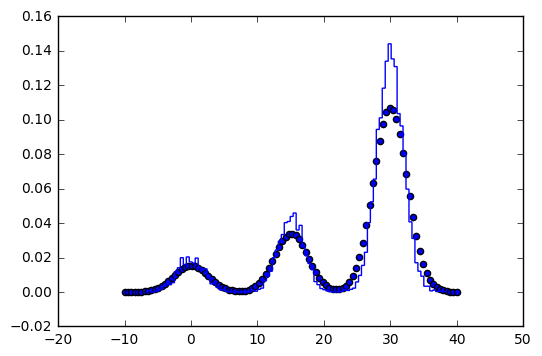

In [28]:
kernel = gaussian_kde(trace_nuts.get_values(gri2d.name)[:,0])
plt.scatter(np.linspace(-10,40,100), kernel(np.linspace(-10,40,100)))
plt.hist(trace_nuts.get_values(gri2d.name)[:,0], histtype='step', normed=True, bins=100);

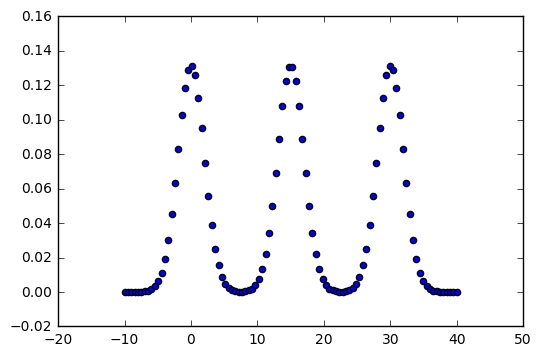

In [79]:
s = np.linspace(-10,40,100)
Z_marginalize = lambda x: np.sum([np.exp(gri2d.logp([x,y])) for y in s])
Z_marginalize_vector = np.vectorize(Z_marginalize)

plt.scatter(s, Z_marginalize_vector(s))

### ttest testing

(array([  9.,   2.,   1.,   1.,   2.,   1.,   1.,   1.,   2.,   1.,   2.,
          3.,  14.,  28.,   5.,   3.,   1.,   3.,   1.,   3.,   1.,   2.,
          2.,   4.,   1.,   1.,   0.,   1.,   1.,   3.]),
 array([-0.04077505, -0.03771202, -0.03464899, -0.03158596, -0.02852293,
        -0.0254599 , -0.02239688, -0.01933385, -0.01627082, -0.01320779,
        -0.01014476, -0.00708173, -0.0040187 , -0.00095567,  0.00210736,
         0.00517039,  0.00823342,  0.01129645,  0.01435948,  0.01742251,
         0.02048554,  0.02354857,  0.0266116 ,  0.02967463,  0.03273766,
         0.03580069,  0.03886372,  0.04192675,  0.04498978,  0.04805281,
         0.05111584]),
 <a list of 30 Patch objects>)

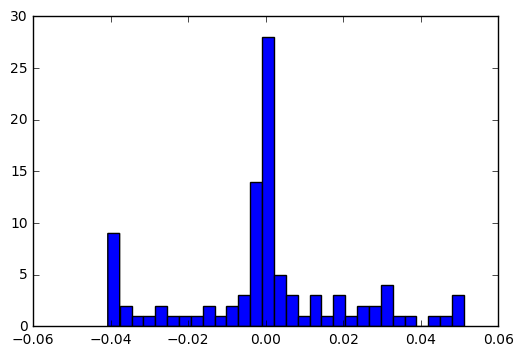

In [55]:
resid = Z_marginalize_vector(s) - kernel(np.linspace(-10,40,100))
plt.hist(resid, bins=30)

In [56]:
from scipy.stats import ttest_1samp

In [57]:
ttest_1samp(resid, popmean=0)

Ttest_1sampResult(statistic=0.00033781441242844868, pvalue=0.99973114287959364)

In [59]:
ttest_1samp(np.random.normal(10,1,size=1000), popmean=0)

Ttest_1sampResult(statistic=313.56171271445641, pvalue=0.0)